In [1]:
%pylab inline

import numpy as np
import tensorflow as tf

from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D

import keras
from keras import optimizers
from keras.models import Model,Sequential,load_model
from keras.layers import Input,Dense,Reshape,Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from keras.utils import plot_model

from IPython.display import clear_output

Populating the interactive namespace from numpy and matplotlib


ImportError: Traceback (most recent call last):
  File "/home/tyler/anaconda3/envs/tensorflowGPU/lib/python3.5/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/home/tyler/anaconda3/envs/tensorflowGPU/lib/python3.5/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/home/tyler/anaconda3/envs/tensorflowGPU/lib/python3.5/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/home/tyler/anaconda3/envs/tensorflowGPU/lib/python3.5/imp.py", line 243, in load_module
    return load_dynamic(name, filename, file)
  File "/home/tyler/anaconda3/envs/tensorflowGPU/lib/python3.5/imp.py", line 343, in load_dynamic
    return _load(spec)
ImportError: libcublas.so.9.0: cannot open shared object file: No such file or directory


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [2]:
def lrz_rhs(t,x,sigma,beta,rho):
    return [sigma*(x[1]-x[0]), x[0]*(rho-x[2]), x[0]*x[1]-beta*x[2]];

In [3]:
end_time = 10
sample_rate = 100
t = np.linspace(0,end_time,sample_rate*end_time+1,endpoint=True)
def lrz_trajectory(rho):
    sigma=10;
    beta=8/3;
    x0 = 20*(np.random.rand(3)-.5)
    sol = integrate.solve_ivp(lambda t,x: lrz_rhs(t,x,sigma,beta,rho),[0,end_time],x0,t_eval=t,rtol=1e-10,atol=1e-11)
    return sol.y

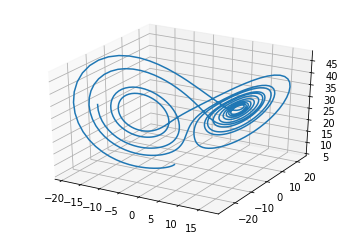

In [4]:
x = lrz_trajectory(28)
plt.figure()
plt.gca(projection='3d')
plt.plot(x[0],x[1],x[2])
plt.show()

## Categorize data by lobe
Pick seperating hyperplane $0 = c^Tx$ where $c=(5,1,0)$

In [5]:
mpl.rcParams['text.usetex'] = True

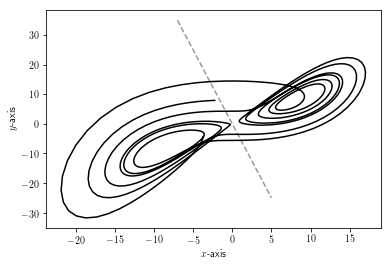

In [209]:
plt.figure()
plt.plot(np.linspace(-7,5),-5*np.linspace(-7,5),color='.6',linestyle='--')
plt.plot(x[0],x[1],color='k')
plt.xlabel('$x$-axis')
plt.ylabel('$y$-axis')
#plt.savefig('img/separating_hyerplane.pdf')

In [5]:
c=([5,1,0])
L=x[:,np.where((c@x).T>=0)[0]]
R=x[:,np.where((c@x).T<0)[0]]

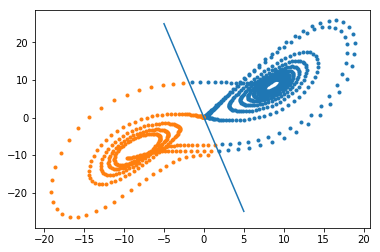

In [6]:
plt.figure()
plt.scatter(L[0],L[1],marker='.')
plt.scatter(R[0],R[1], marker='.')
plt.plot(np.linspace(-5,5),-5*np.linspace(-5,5))
plt.show()

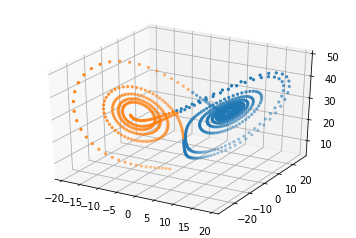

In [7]:
plt3d = plt.figure().gca(projection='3d')
plt3d.scatter(L[0],L[1],L[2],marker='.')
plt3d.scatter(R[0],R[1],R[2],marker='.')
plt.show()

## Generate Data

In [5]:
def generate_timed_trajectory(rho):
    # define normal vector
    c = np.array([5,1,0])
    
    # get trajectory
    x = lrz_trajectory(rho)
    
    # classify points as left or right
    classes = np.sign(c@x)
    # compute which indicies correspond to transitions by 
    #    checking if there is a sign change in classification of points
    transition_ind=np.where(np.convolve(classes,[1,-1],mode='valid')!=0)
    
    # this will be the time it takes to the next jump
    # start with ones where there are jumps
    time_to_jump = np.zeros((len(x.T)))
    time_to_jump[transition_ind] = np.ones(len(transition_ind))    

    # count backwards from ones
    current_time_to_jump = 0
    jumping = False
    for j in range(len(time_to_jump)):
        if time_to_jump[-j]==1:
            current_time_to_jump=1
            jumping=True
        elif jumping:
            time_to_jump[-j]=current_time_to_jump
            current_time_to_jump+=1
    
    # delete end of data where we do not know how long until the next crossing
    ind_to_save = np.where(time_to_jump!=0)[0]
    clipped_data = np.vstack([x,time_to_jump])[:,ind_to_save]
    
    return clipped_data

In [6]:
max_iter = 100
D = np.empty((4,0))
for i in range(max_iter):
    D = np.concatenate([D,generate_timed_trajectory(28)],axis=1)

In [7]:
input_data = D[:3].T
target_data = D[3].T

## Set up Neural Network

In [8]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.yscale('log')
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

def rad_bas(x):
    return K.exp(-x**2)
get_custom_objects().update({'rad_bas': Activation(rad_bas)})

def tan_sig(x):
    return 2/(1+K.exp(-2*x))-1
get_custom_objects().update({'tan_sig': Activation(tan_sig)})

In [9]:
model = Sequential()
model.add(Dense(10, activation='tan_sig', use_bias=True, input_shape=(3,)))
model.add(Dense(10, activation='sigmoid', use_bias=True))
model.add(Dense(10, activation='linear', use_bias=True))
model.add(Dense(1))

In [10]:
sgd1 = optimizers.SGD(lr=0.001, decay=1e-15, momentum=1, nesterov=True)
adam1 = optimizers.Adam(lr=.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-5, amsgrad=True, clipvalue=0.5)
nadam1 = keras.optimizers.Nadam(lr=0.02, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
rmsprop1 = keras.optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0)

In [11]:
model.compile(loss='mean_squared_error', optimizer=adam1, metrics=['accuracy'])

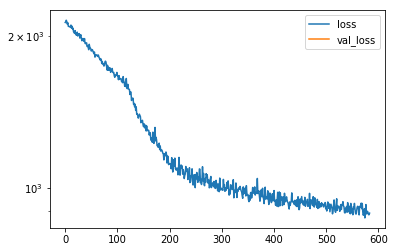

Epoch 585/1000
 9000/89332 [==>...........................] - ETA: 0s - loss: 923.8499 - acc: 0.0192

KeyboardInterrupt: 

In [13]:
mpl.rcParams['text.usetex'] = False
model.fit(input_data, target_data, epochs=1000, batch_size=1000, shuffle=True, callbacks=[plot_losses], validation_split=0.0)

see how model predicts over an entire trajectory.

In [58]:
x = generate_timed_trajectory(28)

next_time_to_jump = np.zeros(len(x.T))
for k,xpos in enumerate(x.T):
    next_time_to_jump[k] = model.predict(np.array([xpos[:3]]))

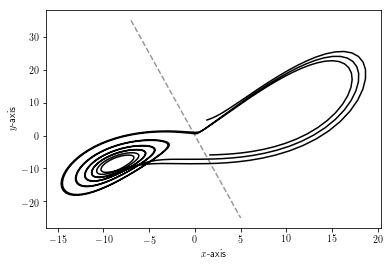

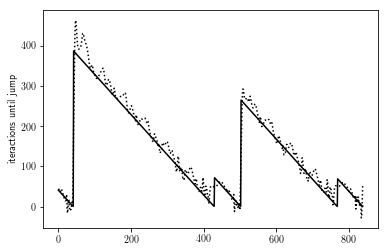

In [60]:
mpl.rcParams['text.usetex'] = True

plt.figure()
plt.plot(np.linspace(-7,5),-5*np.linspace(-7,5),color='.6',linestyle='--')
plt.plot(x[0],x[1],color='k')
plt.xlabel('$x$-axis')
plt.ylabel('$y$-axis')
#plt.savefig('img/separating_hyerplane.pdf')

plt.figure()
plt.plot(np.arange(len(x.T)),x[3], color='k')
plt.plot(np.arange(len(x.T)),next_time_to_jump, color='k', linestyle=':')
plt.ylabel('iteractions until jump')
#plt.savefig('img/jump_predictor.pdf')

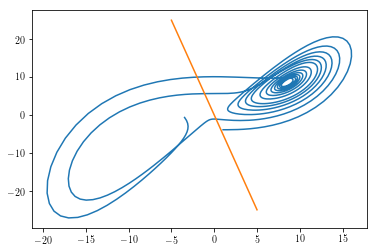

In [108]:
np.shape(x)

(4, 980)

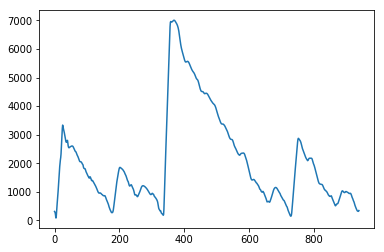

In [190]:
plt.plot(np.arange(len(next_time_to_jump)-19),np.convolve(next_time_to_jump,np.ones(20),mode='valid'))